In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install ultralytics --quiet
from ultralytics import YOLO
import os
import cv2
import matplotlib.pyplot as plt
import glob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.2 MB/s eta 0:00:00:00:0100:01
Creating new Ultral

In [2]:
!ls /kaggle/input

c2a-dataset


In [4]:
!ls -R /kaggle/input/c2a-dataset

/kaggle/input/c2a-dataset:
C2A_Dataset  Coco_annotation_pose

/kaggle/input/c2a-dataset/C2A_Dataset:
new_dataset3

/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3:
'All labels with Pose information'   test   train   val

'/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/All labels with Pose information':
labels	readme.txt

'/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/All labels with Pose information/labels':
collapsed_building_image0001_0.txt  fire_image0511_3.txt
collapsed_building_image0001_1.txt  fire_image0511_4.txt
collapsed_building_image0001_2.txt  fire_image0512_0.txt
collapsed_building_image0001_3.txt  fire_image0512_1.txt
collapsed_building_image0001_4.txt  fire_image0512_2.txt
collapsed_building_image0002_0.txt  fire_image0512_3.txt
collapsed_building_image0002_1.txt  fire_image0512_4.txt
collapsed_building_image0002_2.txt  fire_image0513_0.txt
collapsed_building_image0002_3.txt  fire_image0513_1.txt
collapsed_building_image0002_4.txt  fire_image0513_2.txt
collap

In [5]:
yaml_content = """
path: /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3
train: train/images
val: val/images
test: test/images

names:
  0: class_0
  1: class_1
  2: class_2
  3: class_3
  4: class_4
  5: class_5
"""

with open("data.yaml", "w") as f:
    f.write(yaml_content)

print(" data.yaml created at:", os.path.abspath("data.yaml"))

 data.yaml created at: /kaggle/working/data.yaml


In [7]:
train_images = glob.glob("/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/train/images/*.jpg")[:5]

plt.figure(figsize=(15, 8))
for i, img_path in enumerate(train_images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(train_images), i+1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Sample Training Images", fontsize=16)
plt.show()

<Figure size 1500x800 with 0 Axes>

In [10]:
def plot_image_with_labels(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                cls, x_center, y_center, width, height = map(float, line.split())
                x_center, y_center, width, height = x_center*w, y_center*h, width*w, height*h
                x1, y1 = int(x_center - width/2), int(y_center - height/2)
                x2, y2 = int(x_center + width/2), int(y_center + height/2)
                cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
                cv2.putText(img, str(int(cls)), (x1, y1-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)
    return img

plt.figure(figsize=(15, 8))
for i, img_path in enumerate(train_images):
    img_with_labels = plot_image_with_labels(img_path)
    plt.subplot(1, len(train_images), i+1)
    plt.imshow(img_with_labels)
    plt.axis('off')
plt.suptitle("Sample Images with YOLO Labels", fontsize=16)
plt.show()


<Figure size 1500x800 with 0 Axes>

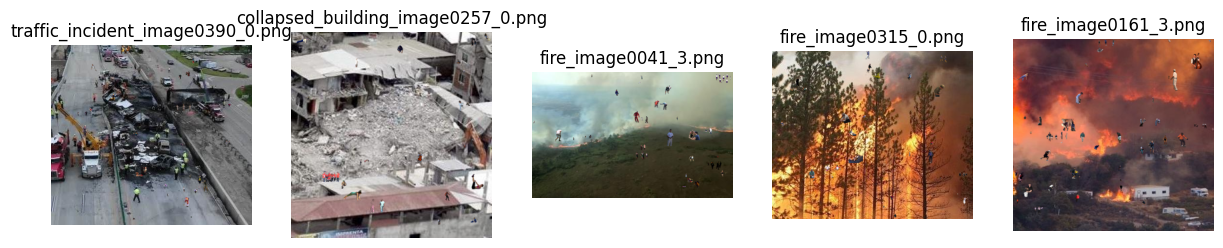

In [20]:
import os
import random
import cv2
import matplotlib.pyplot as plt

def show_sample_images(image_dir, num_images=5):
    # Get all image paths
    image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.lower().endswith(('.jpg', '.png'))]
    
    # Pick random samples
    sample_paths = random.sample(image_paths, min(num_images, len(image_paths)))
    
    # Plot
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR -> RGB for matplotlib
        plt.subplot(1, len(sample_paths), i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(os.path.basename(img_path))
    plt.show()

# Example: Show 5 sample images from train set
show_sample_images("/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/train/images", num_images=5)


In [18]:
from tqdm import tqdm

In [19]:
from tqdm import tqdm 

def preprocess_images(image_dir):
    for img_path in tqdm(glob.glob(f"{image_dir}/*.jpg")):
        try:
            img = cv2.imread(img_path)
            if img is None:
                os.remove(img_path)
                continue
            img_resized = cv2.resize(img, (640, 640))
            cv2.imwrite(img_path, img_resized)
        except:
            os.remove(img_path)

preprocess_images("/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/train/images")
preprocess_images("/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/val/images")
preprocess_images("/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test/images")

print("Preprocessing complete: resized to 640x640 & cleaned corrupts.")

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

Preprocessing complete: resized to 640x640 & cleaned corrupts.


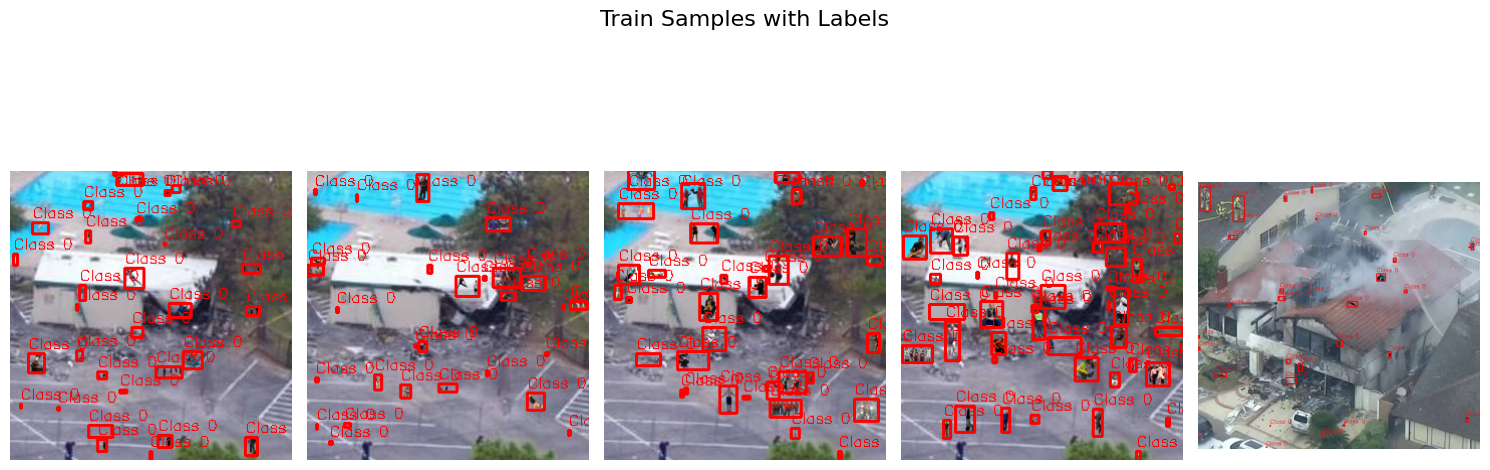

In [30]:
import os
import glob
import cv2
import matplotlib.pyplot as plt

def show_samples_with_labels(image_dir, label_dir, title):
    image_paths = sorted(glob.glob(f"{image_dir}/*.*"))
    plt.figure(figsize=(15, 6))
    plt.suptitle(title, fontsize=16)

    for i, img_path in enumerate(image_paths[:5]):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        # Matching label file (works with .jpg/.png)
        label_path = os.path.join(label_dir, os.path.splitext(os.path.basename(img_path))[0] + ".txt")
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    cls, x, y, bw, bh = map(float, line.strip().split())
                    # Convert YOLO coords to pixels
                    x1 = int((x - bw / 2) * w)
                    y1 = int((y - bh / 2) * h)
                    x2 = int((x + bw / 2) * w)
                    y2 = int((y + bh / 2) * h)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(img, f"Class {int(cls)}", (x1, max(y1 - 5, 15)),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# Paths
base_path = "/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3"

# Row 1: Just images
show_samples_with_labels(f"{base_path}/train/images", f"{base_path}/train/labels", "Train Samples with Labels")


In [12]:
import yaml

# Update dataset config with 6 classes
data_yaml = {
    'train': '/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/train/images',
    'val': '/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/val/images',
    'test': '/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test/images',
    'nc': 6,  # number of classes
    'names': ['standing', 'sitting', 'running', 'walking', 'lying down']
}

with open('data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

print("data.yaml updated successfully!")


data.yaml updated successfully!


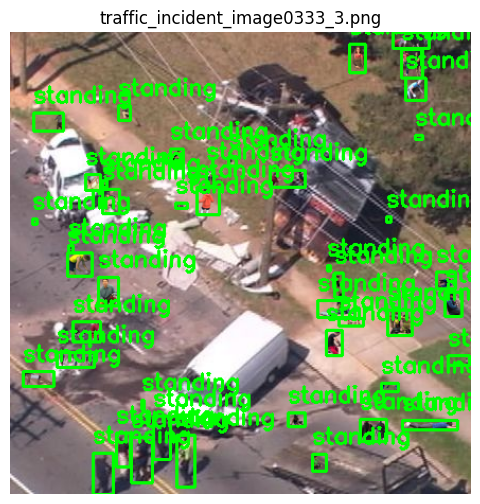

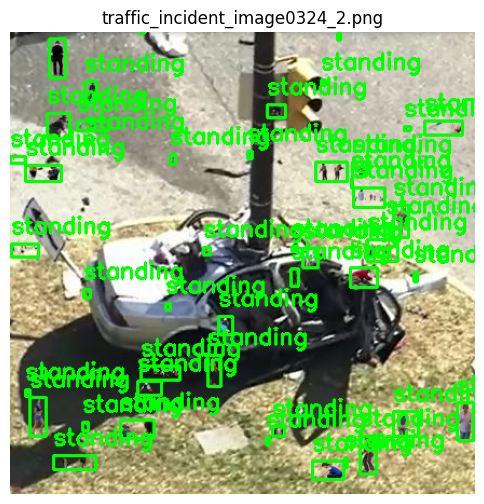

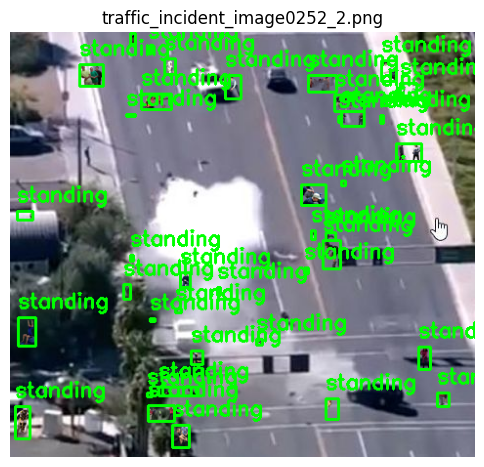

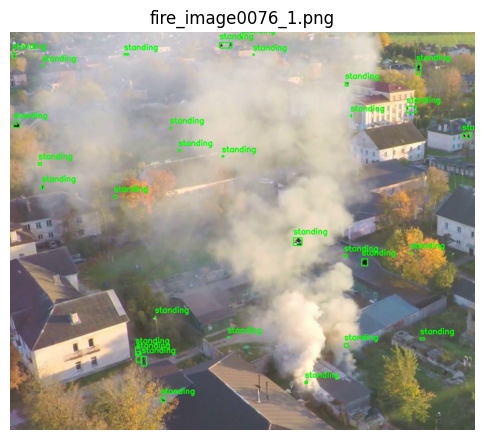

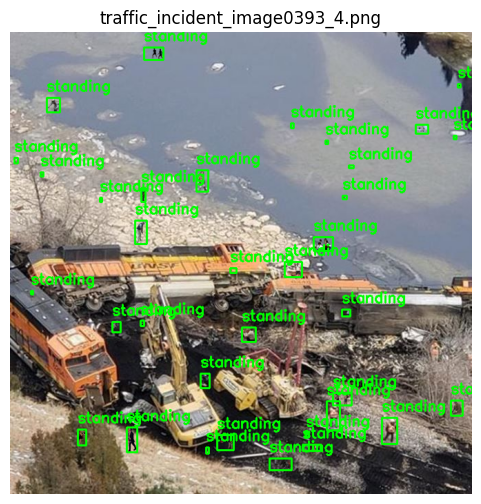

In [16]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Paths (choose val for visualization)
img_dir = "/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/val/images"
label_dir = "/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/val/labels"

# Classes in your dataset
class_names = ['standing', 'sitting', 'running', 'walking', 'lying down']

# Pick 5 random images
image_files = random.sample(os.listdir(img_dir), 5)

for img_file in image_files:
    img_path = os.path.join(img_dir, img_file)
    label_path = os.path.join(label_dir, img_file.replace(".jpg", ".txt").replace(".png", ".txt"))

    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # Draw bounding boxes if label file exists
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                cls, x, y, bw, bh = map(float, line.strip().split())
                cls = int(cls)

                # Convert YOLO -> pixel coords
                x1 = int((x - bw/2) * w)
                y1 = int((y - bh/2) * h)
                x2 = int((x + bw/2) * w)
                y2 = int((y + bh/2) * h)

                # Draw box + label
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img, class_names[cls], (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Show
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_file)
    plt.show()


In [33]:
import os

path = "/kaggle/working"
files = os.listdir(path)

print("Files in folder:", len(files))
for f in files[:20]:  # show first 20 files
    print(f)


Files in folder: 3
c2a_data.yaml
data.yaml
.virtual_documents


In [35]:
import yaml

data_yaml = {
    'train': '/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/train/images',
    'val': '/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/val/images',
    'test': '/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test/images',
    'nc': 4,  # number of classes
    'names': [
        'standing',
        'sitting',
        'walking',
        'lying'   #  replacing 'jumping' with 'lying'
    ]
}

# Save yaml file
with open('c2a_data.yaml', 'w') as f:
    yaml.dump(data_yaml, f, sort_keys=False)

print(" Corrected c2a_data.yaml created!")


 Corrected c2a_data.yaml created!


In [ ]:
import shutil
shutil.make_archive("/kaggle/working/c2a_dataset_preprocessed", 'zip', "/kaggle/working/dataset-folder")

In [36]:
with open("c2a_data.yaml", "r") as f:
    print(f.read())

train: /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/train/images
val: /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/val/images
test: /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test/images
nc: 4
names:
- standing
- sitting
- walking
- lying



In [38]:
!pip install ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 21.4 MB/s eta 0:00:00:00:0100:01
  Attempting unins

In [40]:
model = YOLO("yolov8n.pt")  # you can also try yolov8s.pt for better accuracy

In [ ]:
model.train(
    data="/kaggle/working/c2a_data.yaml",  # path to your yaml file
    epochs=50,          # number of training epochs
    batch=16,           # adjust depending on GPU memory
    imgsz=640,          # training image size
    workers=2           # to avoid Kaggle worker crashes
)

Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/c2a_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretraine

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 68.6±58.3 MB/s, size: 3085.1 KB)


train: Scanning /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/train/labels... 6129 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6129/6129 [00:34<00:00, 178.06it/s]

train: /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/train/images/flood_image0407_3.png: 1 duplicate labels removed


WARNING ⚠️ train: Cache directory /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 41.0±20.5 MB/s, size: 321.9 KB)


val: Scanning /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/val/labels... 2043 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2043/2043 [00:11<00:00, 174.54it/s]


WARNING ⚠️ val: Cache directory /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/val is not writeable, cache not saved.
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.67G      1.708       1.59      1.077         30        640: 100%|██████████| 384/384 [01:49<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.79it/s]


                   all       2043      72123       0.68      0.545       0.58      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.27G      1.559      1.106      1.036        690        640:  19%|█▉        | 73/384 [00:18<01:08,  4.57it/s]


image 1/1 /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test/images/collapsed_building_image0002_3.png: 608x640 33 standings, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)


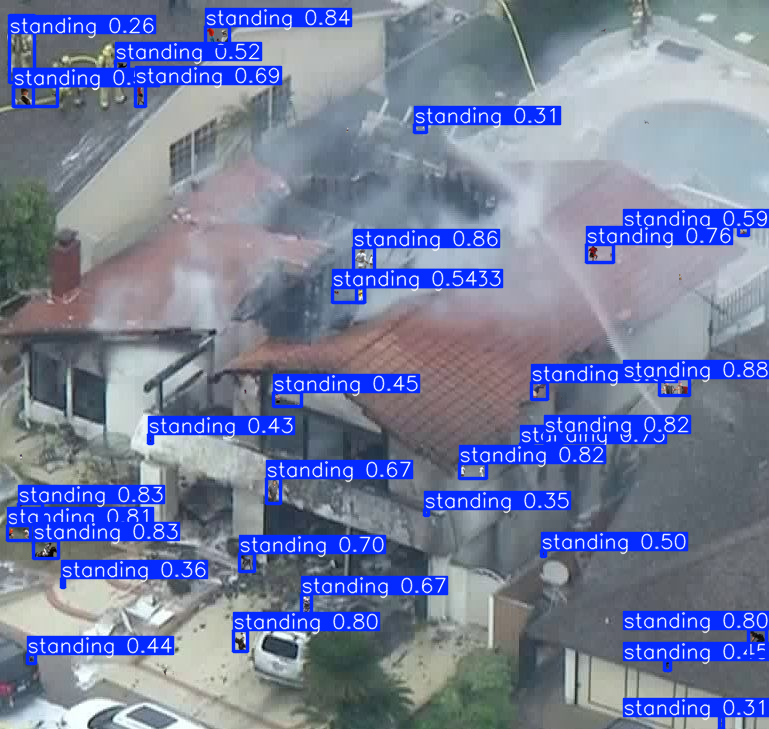

In [66]:
from ultralytics import YOLO

# Load your trained YOLO model
model = YOLO("/kaggle/output/best.pt")

# Run inference on your image
results = model("/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test/images/collapsed_building_image0002_3.png")

# Loop through results (usually only one image)
for r in results:
    r.show()  # Displays image with predictions
